In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## We download the data
#######################

df_train = pd.read_csv('house-prices_preprocess_train.csv')
df_test = pd.read_csv('house-prices_preprocess_test.csv')
df_unseen = pd.read_csv('house-prices_preprocess_unseen.csv')

print('train : ',df_train.shape)
print('test : ',df_test.shape)
print('unseen : ',df_unseen.shape)

train :  (1799, 313)
test :  (486, 313)
unseen :  (500, 313)


In [3]:
## Save the target train/test
y_train = df_train['SalePrice'].values
y_test = df_test['SalePrice'].values

## Drop the target in the DataFrame
df_train = df_train.drop('SalePrice',axis=1)
df_test = df_test.drop('SalePrice',axis=1)
df_unseen = df_unseen.drop('SalePrice',axis=1)

## The Class Model

### Select features for different models

We create a Select function using SelectKBest from sklearn. I found this idea on the 'questions/answers' part of the Project webpage.

In [4]:
## Order the columns with SelectKBest
#####################################

## Put the data in the correct form
X_train = df_train.values  
    
# Create the selecter object
skb = SelectKBest(f_regression, k='all')
    
# Fit the selecter to your data
X_new = skb.fit_transform(X_train,y_train)
    
# Order the columns with respect to the p-values
ordered_cols_pvalues = np.argsort(skb.pvalues_)

## The function that reduce the DataFrame
def Select_Features(df,k):
    
    ## Better to work on a copy
    df = df.copy() 
    ## Order the columns of df
    cols = df.columns[ordered_cols_pvalues[:k]]
    
    return df[cols]

### Polynomial transformation and get split X/y variables

We choose the continuous and ordinal columns as variables to which we want to add polynomial features. In order to avoid colinearity problem, we avoid variables containing too many zeros and not enough values.

In [5]:
## Continuous columns from previous Notebook
continuous = ['Screen Porch','Enclosed Porch','Misc Val','Pool Area',
                  'BsmtFin SF 2','1st Flr SF','Open Porch SF','2nd Flr SF','Mas Vnr Area',
                  'Lot Area','3Ssn Porch','Gr Liv Area','Garage Area','Total Bsmt SF',
                  'Lot Frontage','BsmtFin SF 1','Bsmt Unf SF','Low Qual Fin SF',
                  'Wood Deck SF','Year Built','Year Remod/Add']

## Ordinal columns from previous Notebook
ordinal = ['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond','Exter Qual',
          'Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1',
           'BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional',
           'Fireplace Qu','Garage Finish', 'Garage Qual','Garage Cond','Paved Drive',
           'Pool QC','Fence']

## Columns containing too much zeros 
zero_col = ['Screen Porch','Enclosed Porch','Misc Val','Pool Area','BsmtFin SF 2',
            'Open Porch SF', '2nd Flr SF','Mas Vnr Area','3Ssn Porch','BsmtFin SF 1',
            'Low Qual Fin SF','Wood Deck SF']

## Columns containing a too frequent value
too_many = ['Utilities','Land Slope','Exter Cond','Bsmt Cond','BsmtFin Type 2','Electrical',
            'Functional','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']


Exclude = list(set(zero_col).union(set(too_many)))
Union = list(set(continuous).union(set(ordinal)))

poly_cols = [x for x in Union if ((len(df_train[x].value_counts().index)>5) & (x not in Exclude))]
poly_cols

['Lot Area',
 'Lot Frontage',
 'Garage Area',
 'Year Remod/Add',
 'BsmtFin Type 1',
 'Bsmt Qual',
 'Total Bsmt SF',
 'Bsmt Unf SF',
 'Overall Cond',
 'Gr Liv Area',
 'Overall Qual',
 'Year Built',
 '1st Flr SF',
 'Fireplace Qu']

In [6]:
## The function returning X/y variables
#######################################

def get_variables(k,deg): 
    
    ## Select k features and return a DataFrame
    reduced_df_train = Select_Features(df_train,k)
    reduced_df_test = Select_Features(df_test,k)
    reduced_df_unseen = Select_Features(df_unseen,k)
    
    ## Create the polynomial object
    pf_obj = PolynomialFeatures(degree=deg, include_bias=False)
    
    ## Transform the desired columns
    cols_to_transform = [x for x in poly_cols if x in reduced_df_train.columns]
    
    X_train_poly = pf_obj.fit_transform(reduced_df_train[cols_to_transform])
    X_test_poly = pf_obj.transform(reduced_df_test[cols_to_transform])
    X_unseen_poly = pf_obj.transform(reduced_df_unseen[cols_to_transform])

    ## Get complete X variables
    ###########################
    X_train_other = reduced_df_train.drop(cols_to_transform,axis=1).values
    X_test_other = reduced_df_test.drop(cols_to_transform,axis=1).values
    X_unseen_other = reduced_df_unseen.drop(cols_to_transform,axis=1).values

    X_train = np.c_[X_train_poly,X_train_other]
    X_test = np.c_[X_test_poly,X_test_other]
    X_unseen = np.c_[X_unseen_poly,X_unseen_other]
    
    return X_train,X_test,X_unseen

### The Pipeline object

We define our general model using a Pipeline object with the Ridge regression. We will set the parameter alpha to zero for the simple and intermediate model, which corresonds to the usual linear regression and will search for the best alpha value in the complex model.

In [7]:
## The Pipeline object
######################

model = Pipeline([
        ('scaler',StandardScaler()),
        ('ridge',Ridge())
])

### Definition of the Class Model

We decide to define a Model as a class containing as attributes all important informations about the ridge regression. For instance coefs, intercept term, scores mae mse and all different variables X_tr, y_tr,...

In [8]:
## The Class Model
##################

class Model:
    
   ## The constructor of the class
    ###############################
    def __init__(self,k,deg,alpha,random_state):
        
        ## Get variables
        X_train,X_test,X_unseen = get_variables(k,deg)

        ## Fix the alpha in the ridge regression
        model.set_params(ridge__alpha=alpha)
        
        ## Fit the ridge regression
        model.fit(X_train,y_train)
        
        ## Compute predictions
        y_pred_te, y_pred_tr = model.predict(X_test), model.predict(X_train)
        y_pred_un = model.predict(X_unseen)
        
        ## Compute the MAE and MSE scores
        mae_te = MAE(((np.e)**y_test),((np.e)**y_pred_te)) ## recall that we applied
        mae_tr = MAE(((np.e)**y_train),((np.e)**y_pred_tr)) ## log(x+1) to the target
        mse_te = MSE(y_test,y_pred_te)
        mse_tr = MSE(y_train,y_pred_tr)
        
        ## List of attributes we need
        self.mae_te, self.mae_tr = mae_te, mae_tr
        self.mse_te, self.mse_tr = mse_te, mse_tr
        self.y_pred_un = y_pred_un
    
    ## A method that print all the scores
    #####################################
    def print_scores(self,string):
        print('MAE test '+string+' model = {:.3f}'.format(self.mae_te))
        print('MAE train '+string+' model = {:.3f}'.format(self.mae_tr))
        print('MSE test '+string+' model = {}'.format(self.mse_te))
        print('MSE test '+string+' model = {}'.format(self.mse_tr))
    
    ## Return the desired DataFrame of predictions
    ##############################################
    def get_predictions(self):
        df = pd.read_csv('house-prices-test.csv')
        PID = df['PID'].values
        price = np.e**(self.y_pred_un)-1
        pred = [int(x) for x in price]  ## Get the integer part
        predictions_df = pd.DataFrame({'PID':PID,'SalePrice':pred})
        return predictions_df

## Testing three different models

We will create three instances of the class Model corresponding to a simple with three features, an intermediate with 20 columns and a complex model with all the features. For the last one, we will apply the cross validation and grid search technique.

In [9]:
## The simple model
###################
Simple_model = Model(k=3,deg=2,alpha=0,random_state=0)

## Print the different scores
Simple_model.print_scores('simple')

MAE test simple model = 23730.485
MAE train simple model = 24780.048
MSE test simple model = 0.03887648928755171
MSE test simple model = 0.03393008597428399


In [10]:
## The intermediate model
#########################
Intermediate_model = Model(k=20,deg=2,alpha=0,random_state=0)

## Print the different scores
Intermediate_model.print_scores('intermediate')

MAE test intermediate model = 15731.531
MAE train intermediate model = 16409.085
MSE test intermediate model = 0.023592382467519286
MSE test intermediate model = 0.0169555930968071


### The complex model

Since we are dealing with several variables, it is convenient to add regularization to our model. For this we will look for the best alpha value in the Ridge regression and then average over 10 different sample of the data.

In [11]:
## Cross validation
###################

## Store the results
gs_result = []
## The total number of columns
k = len(df_train.columns)

## Average over 10 sample
#########################
for run in range(10):
    
    ## Grid the alpha
    #################
    for alpha in np.logspace(-2,4,num=30):
    
        ## Create the model
        model_grid = Model(k=k,deg=2,alpha=alpha,random_state=run)
        
        ## Save the results
        gs_result.append({
            'alpha' : alpha,
            'train_mse' : model_grid.mse_tr,
            'train_mae' : model_grid.mae_tr,
            'test_mse' : model_grid.mse_te,
            'test_mae' : model_grid.mae_te
        })
        
## Create the DataFrame to store the values
###########################################
Ridge_result = pd.DataFrame(gs_result)
Ridge_result.head()

,alpha,test_mae,test_mse,train_mae,train_mse
0,0.010000,12504.625548,0.016410,10486.944254,0.007319
1,0.016103,12499.052524,0.016339,10491.915081,0.007335
2,0.025929,12490.055112,0.016258,10499.052943,0.007354
3,0.041753,12476.785844,0.016171,10510.123370,0.007377
4,0.067234,12458.124742,0.016082,10523.228436,0.007406


In [12]:
## Group by alpha values
########################
grouped_alpha = Ridge_result.groupby('alpha')

In [13]:
## Extract best alpha with respect to the MAE score
###################################################

best_alpha = grouped_alpha.test_mae.mean().idxmin()
best_score = grouped_alpha.get_group(best_alpha) # the frame with all indices = best_alpha

## The variables we need for the validation curve
mean_tr = grouped_alpha.train_mae.mean()
mean_te = grouped_alpha.test_mae.mean()
std_tr = grouped_alpha.train_mae.std()
std_te = grouped_alpha.test_mae.std()
alphas = grouped_alpha.mean().index

## Print the best values
print('Best alpha = {}'.format(best_alpha))
print('MSE score = {}'.format(best_score.test_mse.mean()))
print('MAE score = {:.2}'.format(best_score.test_mae.mean()))

Best alpha = 0.4520353656360243
MSE score = 0.01579345299568041
MAE score = 1.2e+04


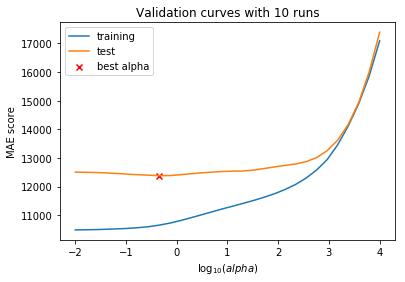

In [14]:
## The validation curve
#######################

## The mean
plt.plot(np.log10(alphas),mean_tr,label='training')
plt.plot(np.log10(alphas),mean_te,label='test')

## The std
plt.fill_between(np.log10(alphas), mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
plt.fill_between(np.log10(alphas), mean_te-std_te, mean_te+std_te, alpha=0.2)

## Best alpha
plt.scatter(np.log10(best_alpha),best_score.mean().test_mae,marker='x',c='red',
            label='best alpha')

## Labels and legend
plt.title('Validation curves with 10 runs')
plt.xlabel('$\log_{10}(alpha)$')
plt.ylabel('MAE score')
plt.legend()
plt.show()

In [15]:
## Define the complex model
###########################
Complex_model = Model(k=k,deg=2,alpha=best_alpha,random_state=0)

## Print the scores
Complex_model.print_scores('complex')

MAE test complex model = 12384.332
MAE train complex model = 10654.322
MSE test complex model = 0.01579345299568041
MSE test complex model = 0.007625566696866696


### The baseline model

In [16]:
## The baseline model
#####################
baseline_model_te = np.full_like(y_test,np.median(y_train))
baseline_model_tr = np.full_like(y_train,np.median(y_train))


mae_baseline_te = MAE((np.e**baseline_model_te),(np.e**y_test))
mae_baseline_tr = MAE((np.e**baseline_model_tr),(np.e**y_train))
mse_baseline_te = MSE(baseline_model_te,y_test)
mse_baseline_tr = MSE(baseline_model_tr,y_train)

## Print the scores
print('MAE test baseline = ',mae_baseline_te)
print('MAE train baseline = ',mae_baseline_tr)
print('MSE test baseline = ',mse_baseline_te)
print('MSE train baseline = ',mse_baseline_tr)

MAE test baseline =  53240.51646090533
MAE train baseline =  50897.14174541408
MSE test baseline =  0.15985680470223648
MSE train baseline =  0.1338326738784423


### Plotting the different MAE scores

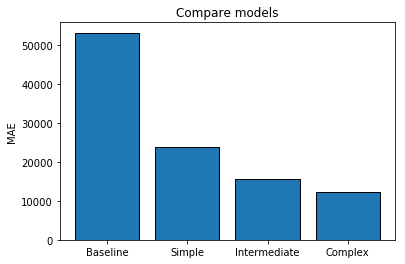

In [17]:
## Plot the different MAE scores
################################

plt.bar([1,2,3,4],[mae_baseline_te,Simple_model.mae_te,Intermediate_model.mae_te,
                  Complex_model.mae_te],edgecolor='black')
plt.xticks([1,2,3,4],['Baseline','Simple','Intermediate','Complex'])
plt.title('Compare models')
plt.ylabel('MAE')
plt.show()

We see that the mean absolute error becomes smaller when the model is more complex, i.e. there are more features.

## Get predictions

In [18]:
## Get the df
simple_predictions_df = Simple_model.get_predictions()
intermediate_predictions_df = Intermediate_model.get_predictions()
complex_predictions_df = Complex_model.get_predictions()

In [19]:
## Save in csv files
simple_predictions_df.to_csv('prediction-simple-model.csv',index=False, encoding='utf-8')
intermediate_predictions_df.to_csv('prediction-intermediate-model.csv',index=False, 
                                                                       encoding='utf-8')
complex_predictions_df.to_csv('prediction-complex-model.csv',index=False, encoding='utf-8')

If we assume that the 500 houses have been choosen randomly, then our predictions should have approximatively the same distribution as in the original training set.
We can check for example the basic statistics associated to these predictions and original data.

In [20]:
## Check on the complex model
#############################
complex_predictions_df['SalePrice'].describe()

count       500.000000
mean     183054.034000
std       82509.462963
min       37193.000000
25%      129592.000000
50%      161409.000000
75%      214733.000000
max      677398.000000
Name: SalePrice, dtype: float64

In [21]:
## The original training set
pd.Series(np.e**(y_train)-1).describe()

count      1799.000000
mean     178473.350750
std       68510.765583
min       37900.000000
25%      130000.000000
50%      162500.000000
75%      212999.500000
max      535000.000000
dtype: float64

We note that the basic statistics coincide pretty well. Only the standard deviation is bigger in the predicted set. Let's plot the distributions.

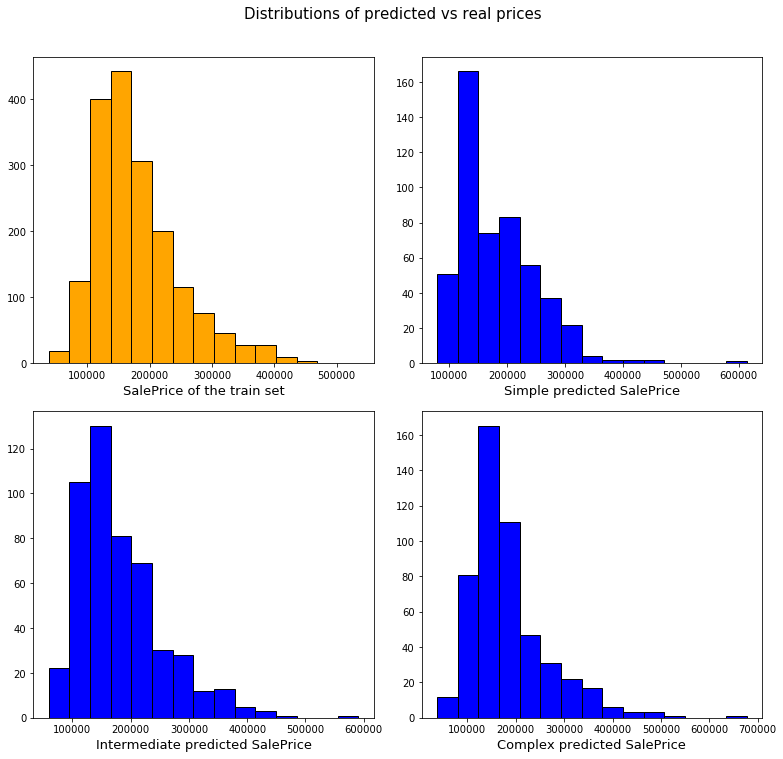

In [22]:
## Plot the distribution 
########################
fig, (ax1,ax2) = plt.subplots(2,2,figsize=(11,10))
## The title
plt.suptitle('Distributions of predicted vs real prices',fontsize=15).set_position([0.5, 1.05])
## Real prices
ax1[0].hist(np.e**(y_train)-1,bins=15,edgecolor='black',color='orange')
ax1[0].set_xlabel('SalePrice of the train set',fontsize=13)
## Simple predicted prices
ax1[1].hist(simple_predictions_df['SalePrice'].values,bins=15,edgecolor='black',color='blue')
ax1[1].set_xlabel('Simple predicted SalePrice',fontsize=13)
## Intermediate predicted prices
ax2[0].hist(intermediate_predictions_df['SalePrice'].values,bins=15,edgecolor='black',color='blue')
ax2[0].set_xlabel('Intermediate predicted SalePrice',fontsize=13)
## Complex predicted prices
ax2[1].hist(complex_predictions_df['SalePrice'].values,bins=15,edgecolor='black',color='blue')
ax2[1].set_xlabel('Complex predicted SalePrice',fontsize=13)

fig.tight_layout()
plt.show()

In [23]:
simple_predictions_df[simple_predictions_df['SalePrice']>=500000]

,PID,SalePrice
194,908154205,613733


We remark that a house has a quite high predicted price, which should be at the origin of the difference between standard deviations. Indeed, very expensive houses have been ignored when filter the outliers.